In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
Fri Apr 11 08:36:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   32C    P8             21W /  300W |   28276MiB /  49140MiB |      0%      Default |
|                                      

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[08:36:38.415] INFO   CaloQVAE                                          Willkommen!
[08:36:38.416] INFO   CaloQVAE                                          Loading configuration.
[08:36:39.972] INFO   numexpr.utils                                     Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[08:36:39.973] INFO   numexpr.utils                                     Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[08:36:39.973] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2025-04-11 08:36:40,783 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[08:36:40.783] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [3]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")
config=compose(config_name="config.yaml")
# config=compose(config_name="config.yaml", overrides=["model=atlasCondQVAE3D"])
config.model.n_layers_per_subdec = 11
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[08:36:43.576] INFO   data.dataManager                                  Loading Data
[08:37:06.390] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f241af81ba0>: 80000 events, 625 batches
[08:37:06.392] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f24d96c0040>: 10000 events, 10 batches
[08:37:06.393] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f24d7fb14e0>: 10000 events, 10 batches
[08:37:08.376] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE3DHD
2025-04-11 08:37:08,392 dw

Initializing NetworkV3
Layer Inputs:  [1208, 2792, 2792, 2792]
Layer Outputs:  [1584, 1584, 1584, 6480]
Raw Layer Indices:  [0, 1584, 1584, 1584, 6480]
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3


In [4]:
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[08:37:12.492] INFO   wandb                                             Watching
/home/luian1/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[08:37:13.224] INFO   engine.engineAtlas                                Setting up engine Atlas.
[08:37:13.225] INFO   engine.engineCaloV3                               Setting up engine Calo.
[08:37:13.226] INFO   engine.engine                                     Setting up default engine.


In [5]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[08:37:34.110] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f22a90839d0>: 80000 events, 625 batches
[08:37:34.113] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f22a9083940>: 10000 events, 10 batches
[08:37:34.114] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f22a90838e0>: 10000 events, 10 batches


In [6]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

import sys
sys.path.append('/path/to/project')

import utils.plotting.HighLevelFeatures as HLF
import h5py
from ipynb.fs.full.utils.plotting.HEPMetrics import get_fpd_kpd_metrics

In [7]:
def search_HEPMetric(path_head, model_name, start_epoch, end_epoch, epoch_int):
    en_list = []
    fpd_recon, fpd_sample = [], []
    kpd_recon, kpd_sample = [], []
    hlf, ref_hlf = None, None
    for en in range(start_epoch, end_epoch, epoch_int):
        run_path = path_head + str(en) + ".pth"
        modelname = model_name
        datascaled = 'reduced'
        open_path = path_head.replace(path_head.split('/')[-1], '') + "config.yaml"
        with open(open_path, 'r') as file:
            model_config = yaml.safe_load(file)
            R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
            reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
            scaled=False
            
        arch = config['model']['model_type']
        part = config['data']['particle_type']
        modelCreator.load_state(run_path, dev)
        engine.model.eval();

        # get the samples
        xtarget_samples = []
        xrecon_samples = []
        xgen_samples = []
        xgen_samples_qpu = []
        n_samples4_qpu = 200
        
        # xrecon_samples_2 = []
        
        # labelstarget_samples = []
        # labelsrecon_samples = []
        entarget_samples = []
        with torch.no_grad():
            for xx in train_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in val_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in test_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)
        
        # xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)
        if en == start_epoch:
            print("First epoch")
            hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            ref_hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            hlf.Einc = entarget_samples

        recon_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
        sample_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xgen_samples), False, hlf, ref_hlf)

        en_list.append(en)
        fpd_recon.append(recon_HEPMetrics[0])
        kpd_recon.append(recon_HEPMetrics[2])
        fpd_sample.append(sample_HEPMetrics[0])
        kpd_sample.append(sample_HEPMetrics[2])
        print("Finished generating HEP Metrics for epoch " + str(en) + " ...")
    return en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample

In [ ]:
path_head = "/fast_scratch_1/caloqvae/luian1/wandb/run-20250331_225402-82osmz27/files/AtlasConditionalQVAE3DHD_atlas_default_"
model_name = 'lunar-forest-676'
HEPMetric_output = search_HEPMetric(path_head, model_name, 10, 251, 10)

[08:37:34.894] INFO   models.modelCreator                               Loading state
[08:37:35.279] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250331_225402-82osmz27/files/AtlasConditionalQVAE3DHD_atlas_default_10.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


[0.2855073243118507, 0.2851073237454691, 0.30934097675536654, 0.21607445233463798, 0.23190160060757506, 0.22284842854669543, 0.29692361803515094, 0.33392644731516546, 0.19372678914111668, 0.4564865186043407, 0.2321312675912637, 0.17674124205199435, 0.16946045102898216, 0.169050859729013, 0.4039976800529817, 0.21377935708184054, 0.1387547892301925, 0.1138348743706359, 0.14345394313783744, 0.18988171795261471, 0.1032659640014486, 0.11133399096334473, 0.11184247020688234, 0.1102094675563415, 0.10712495962223093] [0.0009040011169889617, 0.0005911176388322392, 0.0016373758915593228, 0.001036259692989816, 0.0017217025355462656, 0.0011502004155907741, 0.0017213840813148362, 0.002061192445197202, 0.0011215283318377622, 0.0036931387321355036, 0.0017352310423286443, 0.0004777063579806118, 0.0007532712190037039, 0.0007316756148025849, 0.002781690059941777, 0.001489726595770513, 0.0006386082948004468, 0.0004778312892970149, 0.0010076868686954565, 0.0016346707609193878, 0.0004590694224040348, 0.000

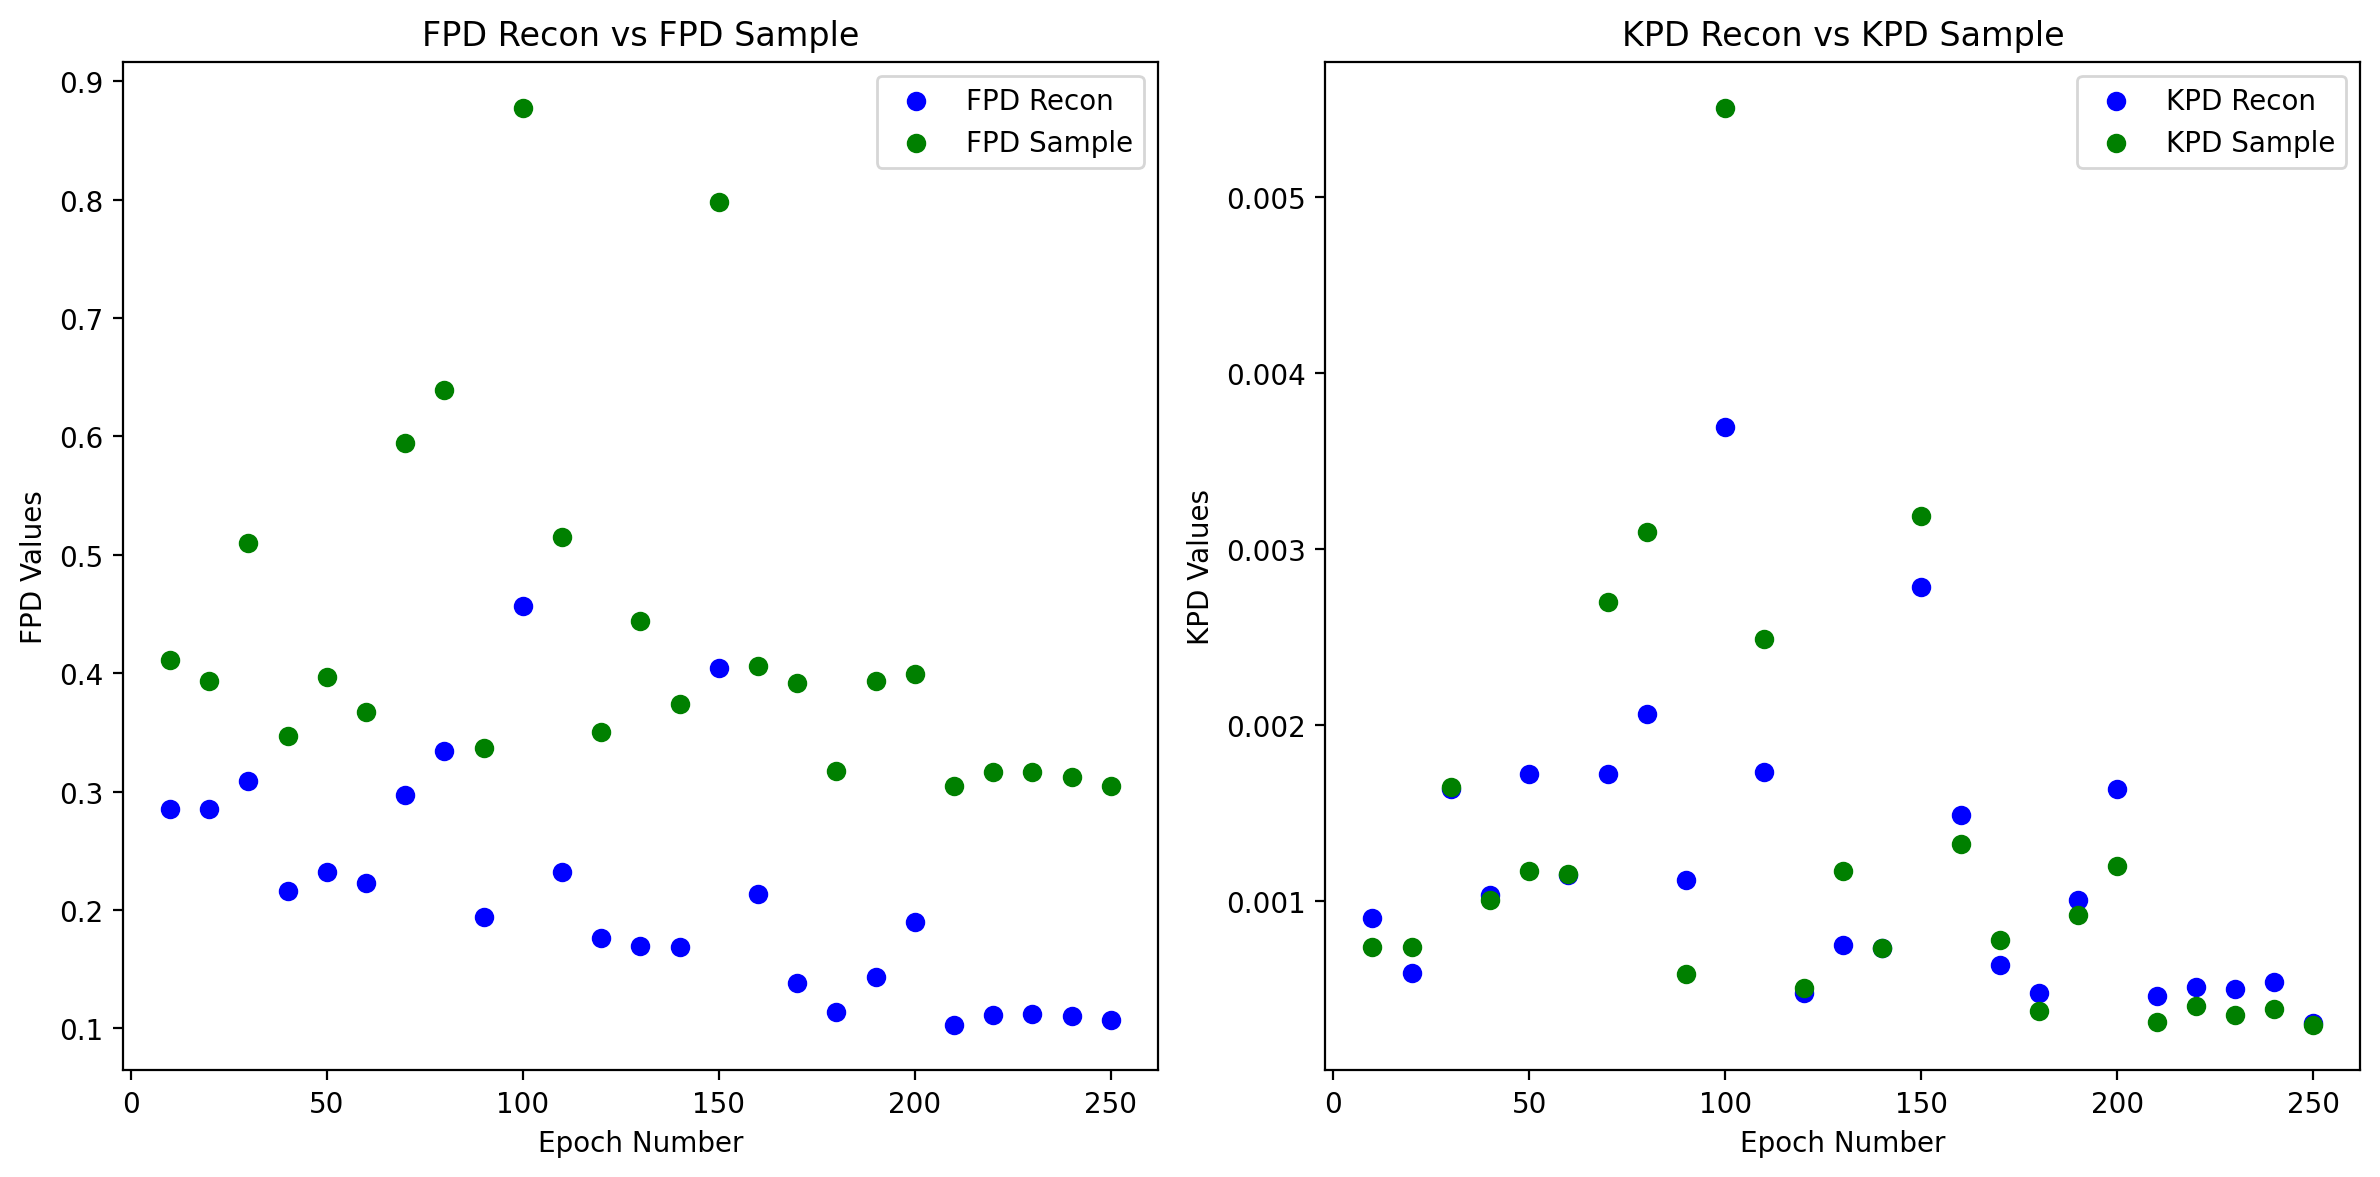

In [11]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon, color='blue', label='FPD Recon')
ax1.scatter(en_list, fpd_sample, color='green', label='FPD Sample')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon, color='blue', label='KPD Recon')
ax2.scatter(en_list, kpd_sample, color='green', label='KPD Sample')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
en_list = en_list[:-1]

fpd_sample_5 =[0.553154480837, 0.6136602845359665, 0.5418429152968494, 0.5541726356428696, 0.6685273870796599, 0.6110967270331354, 0.6289733041223445, 0.6372061092455328, 0.6463490871206803, 0.7498346732841865, 0.6454138672871149, 0.8550928986808846, 0.6588600780842779, 0.7302379180956416, 0.6449292652132255, 0.7558994408472602, 0.7224931232611151, 0.5260006008460525, 0.818749214111163]
kpd_sample_5 =[0.0018318757357498328, 0.0018130663832041094, 0.0010163020951583501, 0.0016337097995502425, 0.002088667959990742, 0.0016846208488883185, 0.00228773695145823, 0.0027561552124695243, 0.003103582576664543, 0.0031995247953175987, 0.003184767570885594, 0.005684983283809064, 0.0037083012985821284, 0.003675151340920335, 0.0034149798570570766, 0.004377564692052527, 0.005187627455549126, 0.0021212988364291974, 0.004431905073538633]
fpd_sample_8 =[0.5929660106944847, 0.6137928734449476, 0.5897238339354434, 0.5909743350993697, 0.5677621305084241, 0.5764988672114609, 0.7093113221681896, 0.6096127463346588, 0.8486751884792727, 0.5219882629160867, 0.8975275063472021, 0.7447859362830084, 0.6489150656614426, 0.778547176111181, 0.5237129605716582, 0.5316587798065304, 0.7244082953189731, 0.8596122341104552, 0.7926742165030413]
kpd_sample_8 =[0.001518541892266967, 0.001333552678007388, 0.002030611735795551, 0.0013844218654301965, 0.002729218878973594, 0.0013616238506497513, 0.004671638355415952, 0.004000268570254706, 0.005523119115335318, 0.0018274169987104738, 0.0054349368733812575, 0.004571673249409658, 0.0025784400518606976, 0.0059641467096887, 0.002328656726959366, 0.002757509383109147, 0.004918346055249989, 0.005572564479612074, 0.004624145202613672]
fpd_sample_11 = [0.6340750192643474, 0.6634647937340336, 0.6250826561705985, 0.604657453152671, 0.5768301233552284, 0.661369383114132, 0.5528745806728821, 0.6132791487678578, 0.8335492874686207, 0.6547540352298769, 0.5855208760125387, 0.6047352721785548, 0.6167268222003582, 0.50350109195107, 0.6077360311237109, 0.5557535828757477, 0.6857949898664384, 0.6810248059802353, 0.6575340966367252]
kpd_sample_11 = [0.0019473151879876305, 0.002249515852575046, 0.002049303456659324, 0.0016571327630654498, 0.0016620722153468659, 0.001881095385791065, 0.0022569241806080775, 0.002587297390754806, 0.0033651197153912182, 0.0023334313885012836, 0.0022847191719042037, 0.0029425713878490356, 0.00270076514232942, 0.0021808915228411774, 0.0022169362588397856, 0.0018470354689203994, 0.0029638605274635577, 0.0032089509878328037, 0.003875187187815543]
fpd_sample_14 =[0.6044120336259733, 0.5931731894556472, 0.6252257378887611, 0.6149250124169393, 0.585088308336629, 0.7037802405956701, 0.7505552777433623, 0.7221755389035971, 0.6113717421685303, 0.6042867394025573, 0.7183173044241418, 0.6778281161133277, 0.8093322762372482, 0.6390644933405912, 0.6386821512465046, 0.6433453734591881, 0.798787554654026, 0.7259910313382832, 0.800634546884362]
kpd_sample_14 =[0.0018016730244163615, 0.0017154013781928157, 0.0023478456449690377, 0.001993203679681921, 0.002116072716698003, 0.002293594434152002, 0.002147267090483629, 0.00382360141307192, 0.0031295436681308964, 0.002337308486286327, 0.0033189200491756665, 0.00314063358571115, 0.003655873705991297, 0.002276956587653034, 0.0026814857054953123, 0.0027013192611282655, 0.004196359334906141, 0.003947055315695724, 0.0033880908189201087]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_sample_5, color='blue', label='size 5')
ax1.scatter(en_list, fpd_sample_8, color='green', label='size 8')
ax1.scatter(en_list, fpd_sample_11, color='red', label='size 11')
ax1.scatter(en_list, fpd_sample_14, color='orange', label='size 14')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_sample_5, color='blue', label='size 5')
ax2.scatter(en_list, kpd_sample_8, color='green', label='size 8')
ax2.scatter(en_list, kpd_sample_11, color='red', label='size 11')
ax2.scatter(en_list, kpd_sample_14, color='orange', label='size 14')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()